# Small color patch model (with pixel scaling)

Refine the model trained in DF_Filter.016  
Here, apply pixel scaling. (Remember to scale during inference!)  
TO DO: use data augmentation (https://keras.io/examples/vision/image_classification_from_scratch/)  

Directory structure is
* cache  
    * train  
        * green  2452 files
        * blue   2847 files
    * valid  
        * green  496 files
        * blue   565 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "CNN_SMALL_COLOR"
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)

Will overwrite model at /home/jrm/Martinez/models/CNN_SMALL_COLOR


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 5297 files belonging to 2 classes.
Found 1059 files belonging to 2 classes.


In [10]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
iterator = valid_dataset.take(1)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0], shape=(32,), dtype=int32)


In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 2
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    kl.Conv2D(64,5,activation=ACTIVATION,padding="SAME",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(16,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])
# After rescaling pixels to (0,1), model learns faster than before and hits 100% accuracy.

In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
166/166 [==============================] - 13s 65ms/step - loss: 0.0644 - accuracy: 0.9872 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 2/10
166/166 [==============================] - 10s 62ms/step - loss: 0.0281 - accuracy: 0.9972 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/10
166/166 [==============================] - 10s 63ms/step - loss: 0.0191 - accuracy: 0.9992 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/10
166/166 [==============================] - 10s 62ms/step - loss: 0.0166 - accuracy: 0.9989 - val_loss: 0.0014 - val_accuracy: 0.9991
Epoch 5/10
166/166 [==============================] - 10s 62ms/step - loss: 0.0130 - accuracy: 0.9989 - val_loss: 8.6873e-04 - val_accuracy: 1.0000
Epoch 6/10
166/166 [==============================] - 10s 63ms/step - loss: 0.0101 - accuracy: 0.9996 - val_loss: 5.1664e-04 - val_accuracy: 1.0000
Epoch 7/10
166/166 [==============================] - 10s 63ms/step - loss: 0.0088 - accuracy: 0.9998 - val_loss: 4.6182e-04 - v

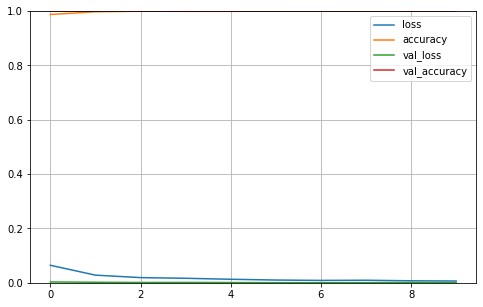

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
cnn.save(filepath)

INFO:tensorflow:Assets written to: /home/jrm/Martinez/models/CNN_SMALL_COLOR/assets
